Scope:

This branch should implement torch functionality in expsolve. 

Once investigations are done, the derivative part needs to go in fourier and splittings, for e.g., to make torch compatible derivatives, and this file should be deleted. 

Torch compatible applications should be in their own specific branches and not included here. 

# Hamiltonian Identification

In [1]:
import numpy as np
import matplotlib.pylab as plt

import expsolve as es
import expsolve.splittings.classical as split
import expsolve.fourier as ex

import torch
from torch import exp, sin, abs, real, imag, pi, diag
from torch.linalg import matrix_exp
import torch.nn as nn

from IPython import display
from torch.optim.lr_scheduler import StepLR

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

True Potential

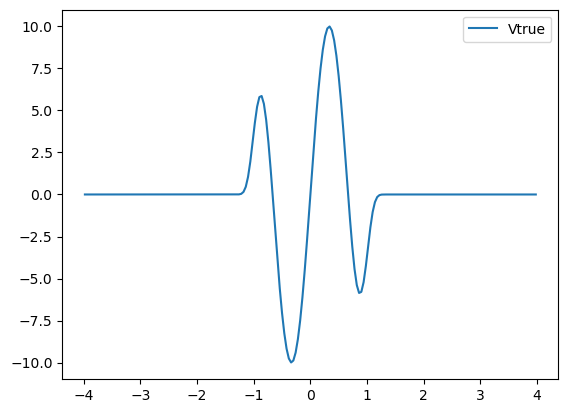

In [3]:
n = 200
L = 4
xr = [-L, L]
x = ex.grid1d(n, xr)

Vtrue = 10.*exp(-x**8/1)*sin(1.5*pi*x)

#plt.xlim(-5,5)
# plt.ylim(-100,200)

plt.plot(x, Vtrue)

plt.legend(['Vtrue'])
plt.show()

Solvers

In [4]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)


solver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), strangstep(V) )[0]

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


Polynomial Ansatz

Dataset

In [5]:
def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))
    u = ex.normalize(u, xr)
    return u

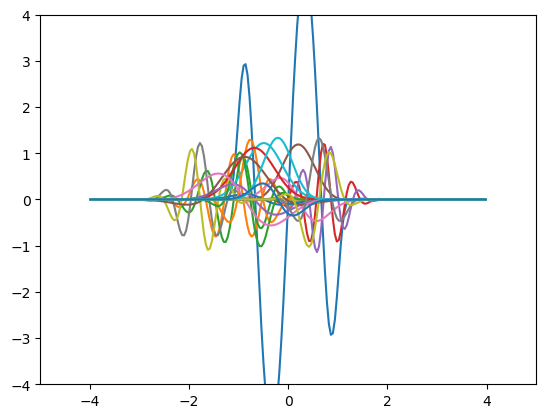

In [6]:
plt.xlim(-5,5)
plt.ylim(-4,4)

plt.plot(x, Vtrue/2)

for i in range(10):
    u0 = ugen(sx0=1.0, svar=0.3, sw0=1.5)
    plt.plot(x, real(u0))
    plt.plot(x, imag(u0))

plt.show()

Maybe the quartic paramterization is very difficult to learn

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
        )
        self.model = self.model.double()    # double precision

    def forward(self, x):
        return self.model(x)

model = SimpleNN()

In [8]:
X = torch.tensor(x.detach().numpy(), dtype=torch.float64).unsqueeze(1)

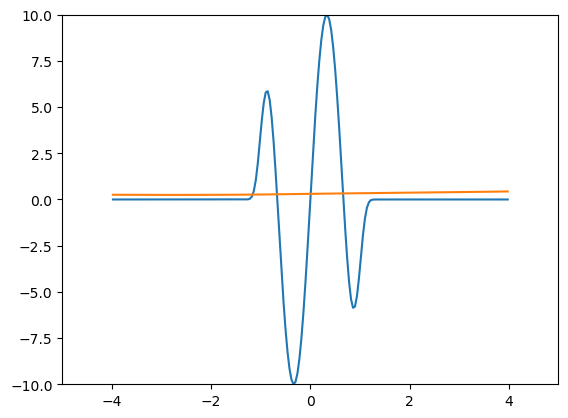

In [9]:
plt.plot(x, Vtrue)
plt.plot(x, model(X).detach().numpy())
plt.xlim(-5,5)
plt.ylim(-10,10)

plt.show()

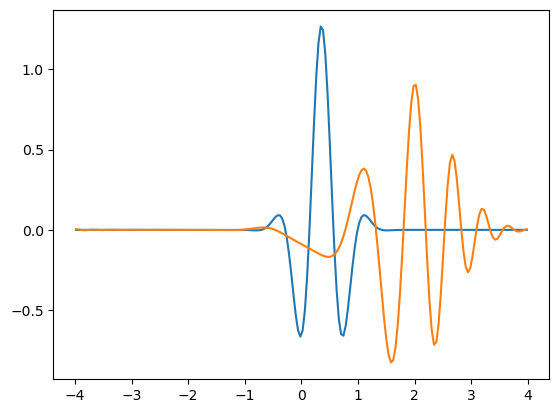

In [10]:
u = ugen(sx0=1.5, svar=0.3, sw0=1.5)
plt.plot(x, real(u))
plt.plot(x, real(solver(Vtrue, u, 0.1, 20)))

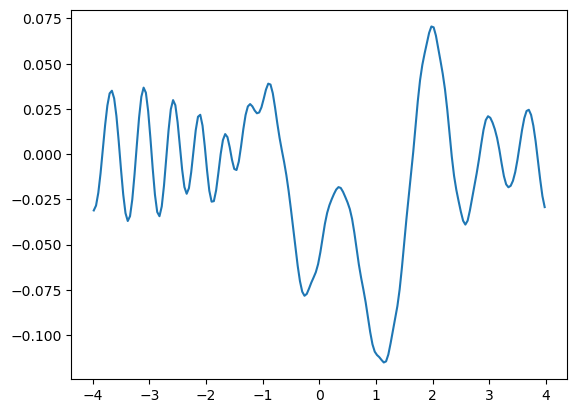

In [11]:
plt.plot(x, real(solver(Vtrue, u, 0.2, 20)-solver(0*Vtrue, u, 0.2, 20)))    # what happens when we get V incorrect
plt.show()

In [12]:

XD = X.to(device)
VD = Vtrue.to(device)

lossfn = lambda V, Vtrue, u, T, N: torch.norm(solver(V, u, T, N) - solver(Vtrue, u, T, N) )**2

#nrm = lambda v: real( sum(v.conj() * v) )
#lossfn = lambda V, u: ex.l2norm(solver(V, u) - solver(Vtrue, u) )**2

def loss_batch(V, Vtrue, nbatch, T, N):
    dx = XD[1]-XD[0]
    #print(dx)

    loss = torch.tensor(0., dtype=torch.float64).to(device)

    for i in range(nbatch):
        u = ugen(sx0=1, svar=0.3, sw0=1.5).to(device)
        L = lossfn(V, VD, u, T, N)
        loss += L
    
    loss = dx * loss/nbatch

    return loss

In [13]:
model.to(device)
V = model(XD)
eLu(0, 0, 0.1, 1, u.to(device))
strangstep(V)(0, 0.1, u.to(device))

tensor([[ 1.8571e-34-1.4792e-34j,  9.2006e-34-3.6395e-34j,
          4.0559e-33-3.2815e-34j,  ...,
          1.5048e-23+2.8149e-23j,  1.8996e-24+9.6184e-24j,
         -2.9952e-25+2.9568e-24j],
        [ 1.8577e-34-1.4787e-34j,  9.2025e-34-3.6364e-34j,
          4.0562e-33-3.2671e-34j,  ...,
          1.5039e-23+2.8156e-23j,  1.8963e-24+9.6197e-24j,
         -3.0061e-25+2.9568e-24j],
        [ 1.8602e-34-1.4792e-34j,  9.2128e-34-3.6356e-34j,
          4.0602e-33-3.2518e-34j,  ...,
          1.5040e-23+2.8189e-23j,  1.8937e-24+9.6296e-24j,
         -3.0223e-25+2.9595e-24j],
        ...,
        [ 1.8417e-34-1.4951e-34j,  9.1586e-34-3.7213e-34j,
          4.0491e-33-3.6538e-34j,  ...,
          1.5295e-23+2.7984e-23j,  1.9869e-24+9.5921e-24j,
         -2.7190e-25+2.9568e-24j],
        [ 1.8440e-34-1.4958e-34j,  9.1685e-34-3.7215e-34j,
          4.0531e-33-3.6428e-34j,  ...,
          1.5299e-23+2.8016e-23j,  1.9853e-24+9.6018e-24j,
         -2.7320e-25+2.9595e-24j],
        [ 1.8445e-34-1

In [14]:
V = model(XD)
solver(V, u.to(device), torch.tensor(0.1).to(device), torch.tensor(10).to(device))

tensor([[ 1.8522e-34-1.4861e-34j,  9.1892e-34-3.6727e-34j,
          4.0554e-33-3.4259e-34j,  ...,
          1.5150e-23+2.8100e-23j,  1.9340e-24+9.6132e-24j,
         -2.8909e-25+2.9583e-24j],
        [ 1.8549e-34-1.4858e-34j,  9.1998e-34-3.6685e-34j,
          4.0590e-33-3.3967e-34j,  ...,
          1.5141e-23+2.8135e-23j,  1.9280e-24+9.6227e-24j,
         -2.9166e-25+2.9605e-24j],
        [ 1.8571e-34-1.4858e-34j,  9.2087e-34-3.6655e-34j,
          4.0622e-33-3.3744e-34j,  ...,
          1.5135e-23+2.8165e-23j,  1.9236e-24+9.6310e-24j,
         -2.9368e-25+2.9625e-24j],
        ...,
        [ 1.8445e-34-1.4883e-34j,  9.1613e-34-3.6907e-34j,
          4.0465e-33-3.5303e-34j,  ...,
          1.5198e-23+2.8004e-23j,  1.9566e-24+9.5893e-24j,
         -2.8042e-25+2.9534e-24j],
        [ 1.8466e-34-1.4882e-34j,  9.1699e-34-3.6880e-34j,
          4.0496e-33-3.5095e-34j,  ...,
          1.5192e-23+2.8032e-23j,  1.9525e-24+9.5972e-24j,
         -2.8232e-25+2.9553e-24j],
        [ 1.8493e-34-1

At step 299, loss is tensor([0.0007], device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


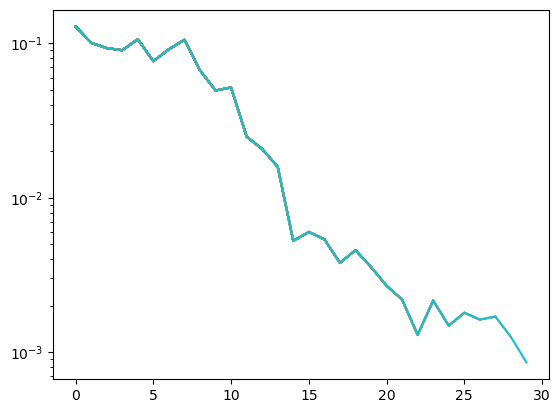

In [15]:
%matplotlib inline

# Create an instance of the SimpleNN model
model = SimpleNN()
model.to(device)

# not sure this is working
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 300

trerror = []


for step in range(num_steps):
    # Compute the loss
    V = model(XD)
    V.requires_grad_()
    V=V.reshape([n])
    loss = loss_batch(V, VD, nbatch=10, T=0.1, N=20)
   
    # print(f'At step {step}, loss is {loss}')

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    if np.mod(step, 10)==0:
        trerror.append(loss.detach().cpu().numpy())        
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)


    # Update parameters using the gradients
    optimizer.step()


print(f'At step {step}, loss is {loss}')

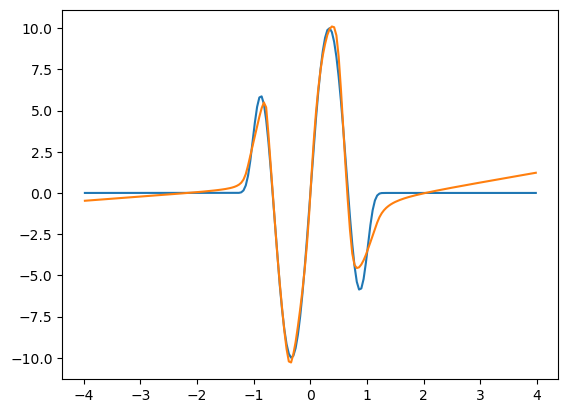

In [17]:
plt.plot(x, Vtrue)
plt.plot(x, V.detach().cpu().numpy())